In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect

In [2]:

class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None, target_col=None) -> None:
        self.datainput = datainput
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler
        self.target_col = target_col
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self) -> pd.DataFrame:
        if self.normalize_bool:
            data = self.scaler.fit_transform(self.datainput)
            return pd.DataFrame(data, columns=self.datainput.columns)
        else:
            return self.datainput

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1 - self.test_size))
            train = data.iloc[:train_idx]
            test = data.iloc[train_idx:]
            return train, test
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs.
        """
        samples = data.shape[0] // self.timestep
        if samples <= 0:
            raise ValueError(
                "The number of samples is less than or equal to 0. Ensure data length is greater than timestep.")
        result = np.array_split(data[:samples * self.timestep], samples)
        return np.array(result)

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0:
            train = train[:-(train_remainder)]
        if test_remainder != 0:
            test = test[:-(test_remainder)]
        # print("train:", train, "test:", test)
        if len(train) < self.timestep or len(test) < self.timestep:
            raise ValueError(
                "Not enough data to form at least one timestep window.")
        train_transformed, test_transformed = self.window_and_reshape(
            train), self.window_and_reshape(test)
        print(f'train_transformed shape: {train_transformed.shape}')
        print(f'test_transformed shape: {test_transformed.shape}')
        return train_transformed, test_transformed

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        print("train:", train, "test:", test)
        return self.transform(train, test)

    def to_supervised(self, data, n_out=5) -> tuple:
        X, y = [], []
        for sample in data:
            if len(sample) >= self.n_input + n_out:
                for i in range(len(sample) - self.n_input - n_out + 1):
                    X.append(sample[i:i + self.n_input])
                    y.append(sample[i + self.n_input:i +
                             self.n_input + n_out, :])
        print(len(sample) - self.n_input - n_out + 1)
        X, y = np.array(X), np.array(y)
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    attention_output, _ = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x, return_attention_scores=True)
    x = layers.Dropout(dropout)(attention_output)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    n_timesteps, n_features, n_outputs = 5, 3, 15
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    masked_inputs = layers.Masking()(inputs)
    # x = inputs
    x = masked_inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_outputs)(x)
    outputs = layers.Reshape((n_timesteps, n_features))(outputs)
    return tf.keras.Model(inputs, outputs)


def fit_transformer(transformer, x_train, y_train, x_val, y_val, display_loss=False):
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape']
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)]

    hist = transformer.fit(x_train, y_train,
                           validation_data=(x_val, y_val),
                           batch_size=32, epochs=25,
                           verbose=1, callbacks=callbacks)

    if display_loss:
        history_df = pd.DataFrame(hist.history)
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()

        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

    return hist

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class PredictAndForecast:
    def __init__(self, model, train, test, n_input=30, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
        print(f"History data reshaped for input: {
              data.shape}")  # Debug statement

        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]

        input_x = input_x.reshape((1, self.n_input, input_x.shape[1]))
        print(f"Input to model for prediction: {
              input_x.shape}")  # Debug statement

        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        print(f"Model prediction: {yhat}")

        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        Compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        print(f"Initial history shape: {len(history)}, {
              history[0].shape}")  # Debug statement

        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        predictions = np.array(predictions)
        print(f"Predictions shape: {predictions.shape}")
        return predictions

    def recursive_predict(self, steps: int) -> pd.Series:
        train_series = pd.Series(self.train.flatten())
        forecaster = ForecasterAutoreg(
            regressor=LinearRegression(), lags=self.n_input)
        forecaster.fit(y=train_series)

        predictions = []
        history = train_series.copy()

        for _ in range(steps):
            next_prediction = forecaster.predict(steps=1)
            predictions.append(next_prediction.values[0])
            history = pd.concat([history, next_prediction])
            forecaster.fit(history)

        prediction_series = pd.Series(predictions, index=pd.date_range(
            start=history.index[-1], periods=steps + 1, freq='D')[1:])
        return prediction_series

    def direct_predict(self, steps: int) -> pd.Series:
        train_series = pd.Series(self.train.flatten(), index=pd.date_range(
            start='2000', periods=len(self.train.flatten())))

        max_steps = min(steps, len(train_series) - self.n_input)

        forecaster = ForecasterAutoregDirect(
            regressor=LinearRegression(), lags=self.n_input, steps=max_steps)
        forecaster.fit(y=train_series)
        predictions = forecaster.predict()
        prediction_series = pd.Series(predictions.values, index=pd.date_range(
            start=train_series.index[-1], periods=max_steps + 1, freq='D')[1:])
        return prediction_series

    def plot_predictions(self, steps: int) -> None:
        recursive_prediction_series = self.recursive_predict(steps)
        direct_prediction_series = self.direct_predict(steps)

        # Ensure both predictions have the same length
        min_steps = min(len(recursive_prediction_series),
                        len(direct_prediction_series))
        recursive_prediction_series = recursive_prediction_series[:min_steps]
        direct_prediction_series = direct_prediction_series[:min_steps]

        plt.figure(figsize=(10, 6))

        # Flatten self.train for plotting
        train_series = self.train.flatten()

        # Plot the training data
        plt.plot(range(len(train_series)), train_series, label='Training Data')

        # Plot the test data
        test_series = self.test.flatten()
        test_start_index = len(train_series)
        plt.plot(range(test_start_index, test_start_index +
                 len(test_series)), test_series, label='Test Data')

        # Adjust prediction indices to align with the start of the test data
        prediction_start_index = test_start_index

        # Plot the recursive predictions
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), recursive_prediction_series.values,
                 label='Recursive Predictions', color='red')
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), direct_prediction_series.values,
                 label='Direct Predictions', linestyle='--')

        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.title('Recursive vs Direct Predictions')
        plt.legend()
        plt.show()

In [5]:
def calculate_TEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = (3 * ema1) - (3 * ema2) + ema3
    return tema.dropna()


def calculate_DEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


ticker = 'NDX'
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

data1 = calculate_DEMA(dataset['Close'], 10)
data2 = calculate_TEMA(dataset['Close'], 10)


dataset_input = pd.DataFrame({
    'Close': dataset['Close'],
    'DEMA': data1,
    'TEMA': data2
})
print(dataset_input)

[*********************100%%**********************]  1 of 1 completed

                   Close          DEMA          TEMA
Date                                                
2020-02-11   9517.860352   9517.860352   9517.860352
2020-02-12   9613.200195   9549.377655   9560.981753
2020-02-13   9595.700195   9566.800728   9581.549439
2020-02-14   9623.580078   9588.635951   9607.056556
2020-02-18   9629.799805   9606.464205   9625.778445
...                  ...           ...           ...
2024-07-29  19059.490234  19068.423821  18867.194304
2024-07-30  18796.269531  18927.468453  18738.971772
2024-07-31  19362.429688  19015.933129  18924.707946
2024-08-01  18890.390625  18930.561745  18848.619119
2024-08-02  18440.839844  18723.472506  18605.040783

[1076 rows x 3 columns]


In [6]:
# Prepare the ETL instance
data = ETL(
    datainput=dataset_input,
    test_size=0.2,
    n_input=5,  # Look-back period
    timestep=10,  # Number of past days to use for each prediction
    normalize_bool=False,
    scaler=StandardScaler()
)

X_train, y_train = data.X_train, data.y_train
X_val, y_val = data.X_test, data.y_test
print(f"X_train shape: {data.X_train.shape}")
print(f"X_test shape: {data.X_test.shape}")
print(f"y_train shape: {data.y_train.shape}")
print(f"y_test shape: {data.y_test.shape}")

train:                    Close          DEMA          TEMA
Date                                                
2020-02-11   9517.860352   9517.860352   9517.860352
2020-02-12   9613.200195   9549.377655   9560.981753
2020-02-13   9595.700195   9566.800728   9581.549439
2020-02-14   9623.580078   9588.635951   9607.056556
2020-02-18   9629.799805   9606.464205   9625.778445
...                  ...           ...           ...
2023-09-05  15508.240234  15441.562755  15564.127829
2023-09-06  15371.440430  15439.852334  15527.694321
2023-09-07  15258.519531  15399.116568  15445.424187
2023-09-08  15280.230469  15374.376504  15395.147095
2023-09-11  15461.870117  15414.748873  15440.310492

[861 rows x 3 columns] test:                    Close          DEMA          TEMA
Date                                                
2023-09-12  15289.740234  15386.430291  15389.764332
2023-09-13  15348.530273  15383.711581  15380.042832
2023-09-14  15473.889648  15422.169716  15428.571636
2023-09-1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy th

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 185414832.0000 - mae: 12432.5146 - mape: 95.0933 - val_loss: 296716672.0000 - val_mae: 15991.3047 - val_mape: 92.3069
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 170365088.0000 - mae: 11877.2129 - mape: 92.4386 - val_loss: 276595264.0000 - val_mae: 15400.5225 - val_mape: 88.8960
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 160629456.0000 - mae: 11468.3955 - mape: 89.0710 - val_loss: 257560656.0000 - val_mae: 14815.2666 - val_mape: 85.5172
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 145984064.0000 - mae: 10896.3438 - mape: 85.1261 - val_loss: 239651984.0000 - val_mae: 14240.3955 - val_mape: 82.1983
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 136512544.0000 - mae: 10492.3672 - mape: 81.7593 - val_loss: 222740304.0000 - val_mae: 13667.9375 - val_mape: 78.8936
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 128232448.0000 - mae: 10183.6191 - mape: 79.1386 - val_loss: 206625056.0000 - 

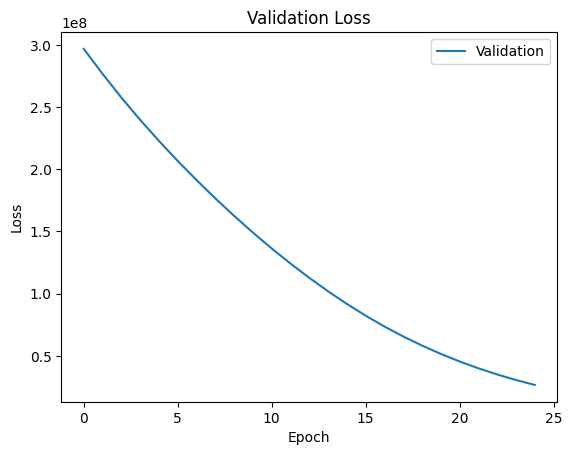

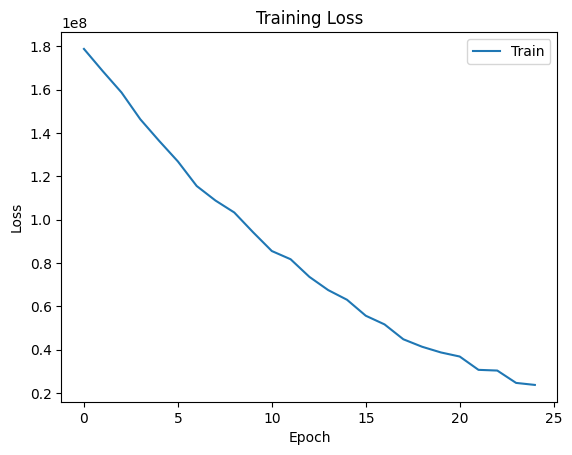

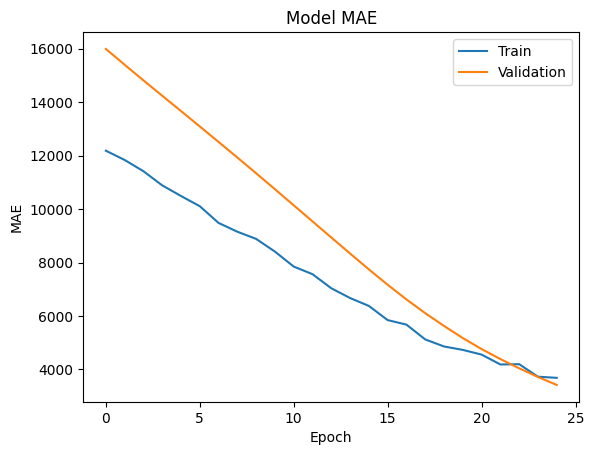

In [7]:
model = build_transformer(head_size=16, num_heads=4,
                          ff_dim=128, num_trans_blocks=6,
                          mlp_units=[64],
                          dropout=0.2, mlp_dropout=0.2)
fit_transformer(model, X_train, y_train, X_val, y_val, display_loss=True)

Initial history shape: 86, (5, 3)
History data reshaped for input: (430, 3)
Input to model for prediction: (1, 5, 3)
Model prediction: [[[14863.906  11468.784  14885.918 ]
  [14375.33   15350.717  13255.342 ]
  [ 8325.392  15266.151  15515.224 ]
  [ 7270.3115 12797.176   3404.631 ]
  [16127.898  12978.722  10459.405 ]]]
History data reshaped for input: (435, 3)
Input to model for prediction: (1, 5, 3)
Model prediction: [[[14995.483 11548.425 15012.189]
  [14450.364 15516.181 13503.284]
  [ 8513.848 15376.472 15702.536]
  [ 7333.352 13033.856  3381.731]
  [16331.887 13233.55  10504.995]]]
History data reshaped for input: (440, 3)
Input to model for prediction: (1, 5, 3)
Model prediction: [[[14330.514  11038.336  14322.34  ]
  [13786.865  14795.083  12860.793 ]
  [ 8112.462  14698.86   14942.063 ]
  [ 6998.1187 12395.501   3259.3577]
  [15591.439  12560.125  10065.759 ]]]
History data reshaped for input: (445, 3)
Input to model for prediction: (1, 5, 3)
Model prediction: [[[14770.346  11

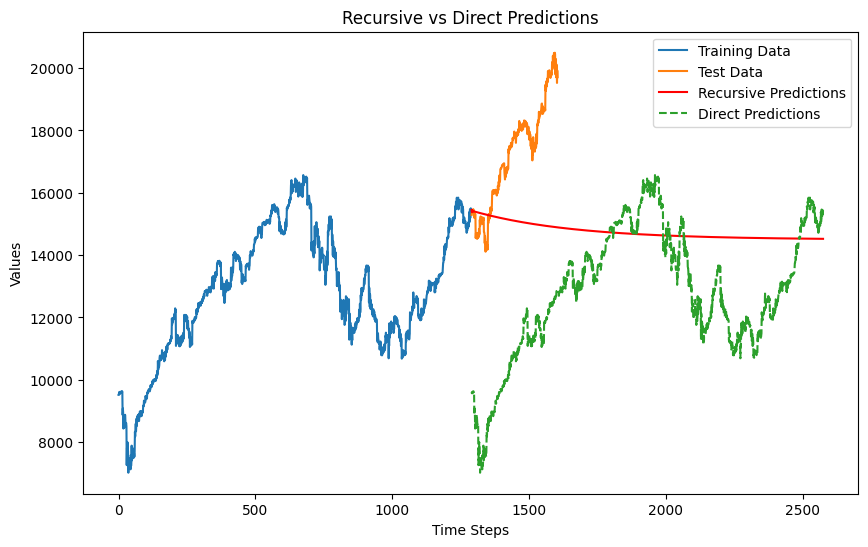

In [21]:
# scaler = StandardScaler()
# train_data = scaler.fit_transform(
#     X_train.reshape(-1, 1)).reshape(X_train.shape)

predict_and_forecast = PredictAndForecast(
    model, X_train, X_val,
    n_input=5, scaler=None,
    normalize_bool=False)

# Get predictions
predictions = predict_and_forecast.get_predictions()
print(f'Predictions shape: {predictions.shape}')

# Plot predictions
predict_and_forecast.plot_predictions(steps=3000)

In [ ]:
# Create an instance of PredictAndForecast
predictor = PredictAndForecast(model, X_train, X_test, n_input=30)

# Predictions for the test set
test_predictions = predictor.predictions

# Forecast the next 10 steps into the future
future_steps = 10
history = [test_predictions[-1].reshape(1, -1, 1)]
# future_forecast = predictor.forecast_future(history, future_steps)

# future_forecast = future_forecast.flatten()
y_test = StandardScaler().inverse_transform(y_test.reshape(-1, 1))
test_predictions = StandardScaler().inverse_transform(
    test_predictions.reshape(-1, 1))
# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(range(len(result['Close'])), result['Close'], label='Actual')
plt.plot(range(len(result['Close']) - len(y_test),
         len(result['Close'])), y_test, label='Test Actual')
plt.plot(range(len(result['Close']) - len(test_predictions),
         len(result['Close'])), test_predictions, label='Predicted')
# plt.plot(range(len(result['Close']), len(result['Close']) +
# future_steps), future_forecast, label='Future Forecast')
plt.title('Actual vs. Predicted and Future Forecast Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Initial history shape: 6926, (30, 1)
History data reshaped for input: (207780, 1)
Input to model for prediction: (1, 30, 1)
Model prediction: [[0.23166487]]
History updated with test data at step 0: 6927, (30, 1)
History data reshaped for input: (207810, 1)
Input to model for prediction: (1, 30, 1)
Model prediction: [[0.21745351]]
History updated with test data at step 1: 6928, (30, 1)
History data reshaped for input: (207840, 1)
Input to model for prediction: (1, 30, 1)
Model prediction: [[0.2237185]]
History updated with test data at step 2: 6929, (30, 1)
History data reshaped for input: (207870, 1)
Input to model for prediction: (1, 30, 1)
Model prediction: [[0.22773173]]
History updated with test data at step 3: 6930, (30, 1)
History data reshaped for input: (207900, 1)
Input to model for prediction: (1, 30, 1)
Model prediction: [[0.23122326]]
History updated with test data at step 4: 6931, (30, 1)
History data reshaped for input: (207930, 1)
Input to model for prediction: (1, 30, 

KeyboardInterrupt: 